I have modified the scripts where each clustering method and embedding method is independently added and can be called specifically based on what we specify. This notebook is to test this and make it ready for easy testing.

What to change in this code?  
- Create more runs
- Parallelise the runs too
- ~~Save the files in a separate folder experiment_mu_change_N/Run1/~~
- Create suitable output pipeline
- Then next experiment: do same for testing different embedding methods against proposed. Same format as above

Rewriting it without parallelisation for Snakemake

In [1]:
import time
import pandas as pd
import numpy as np
from copy import deepcopy
import sys
import os
import csv
from itertools import cycle
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
# warnings.resetwarnings() # To change it back (optional)

sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")

from scripts.similarity_scores import get_scores



def process_and_save_result(run_no, mu, path_name, score_keys, device_name, emb_params, params,csv_file_path):
    start_time = time.perf_counter()

    if not os.path.isdir(f"{path_name}/Run_{run_no}/"):
        os.mkdir(f"{path_name}/Run_{run_no}/")

    params['mu'] = mu
    result_run_mu = get_scores(params, emb_params, score_keys, f"{path_name}/Run_{run_no}/", device_name)
    
    with open(csv_file_path, 'a', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow([run_no, mu] + [result_run_mu[key] for key in score_keys])
        
    elapsed_time = time.perf_counter() - start_time
    
    print(run_no,mu,elapsed_time)
    return run_no, mu, result_run_mu

def save_accumulated_results(results, pathname, score_keys):
    for run_no, mu, result_run_mu in results:
        df = pd.DataFrame.from_dict(result_run_mu, orient='index')
        df.reset_index(inplace=True)
        df.columns = ['mu'] + list(df.columns[1:])
        df.to_csv(f"{pathname}/Run_{run_no}/mu_{mu:.2f}_change.csv", index=False)

accumulator = []  # List to accumulate results for each run and mu

params = {
    "N": 1000,
    "k": 5,
    "maxk": 100,
    "minc": 5,
    "maxc": 100,
    "tau": 2.1,
    "tau2": 1.0,
    "mu": 0.2,
}

emb_params = {
    "method": "node2vec",
    "window_length": 10,
    "walk_length": 80,
    "num_walks": 10,
    "dim": 64,
}

#If you want to test faster for results, remove belief_prop, then optics and dbscan for now and add them separately.
score_keys = ['kmeans','dbscan', 'optics', 'xmeans', 'infomap', 'flatsbm', 'proposed']


num_cores = 10
runs = np.arange(1, 11)
#runs = [1,2]

mu_values = np.round(np.arange(0, 1.05, 0.05),decimals=2)
#mu_values = [0.6, 0.8]
test_run=False

device_names = [f"cuda:{i}" for i in [0,1,2,3]]  # ['cuda:0', 'cuda:1', 'cuda:2', 'cuda:3']

path_name = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_{params['N']}_{params['k']}_{params['tau']}"
if test_run:
    path_name += "_test_run"


#################### End of Params #################

#if not os.path.isdir(path_name):
#    os.mkdir(path_name)

def create_unique_folder(base_folder):
    if os.path.exists(base_folder):
        index = 1
        while True:
            new_folder = f"{base_folder}_{index}"
            if not os.path.exists(new_folder):
                break
            index += 1
    else:
        new_folder = base_folder

    os.mkdir(new_folder)
    return new_folder
    
path_name = create_unique_folder(path_name)
csv_file_path = path_name + "/result_stream.csv"

print("Hello, you can find results at:\n",path_name)

with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(['run_no', 'mu'] + score_keys)

for run_no in runs:
    start_time = time.perf_counter()

    for mu, device_name in zip(mu_values, cycle(device_names)):
        
        run_no, mu, result_run_mu = process_and_save_result(run_no, mu, path_name, score_keys, device_name, emb_params, deepcopy(params),csv_file_path)
        
    print(f"Run took: {time.perf_counter() - start_time}, avg time per mu_val: {(time.perf_counter() - start_time)/len(mu_values)}")


Hello, you can find results at:
 /nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_1000_5_2.1
1 0.0 12.769313156604767
1 0.05 7.588705014437437
1 0.1 10.547407604753971
1 0.15 11.406939171254635
1 0.2 14.424716101959348
1 0.25 12.236353788524866
1 0.3 9.523757284507155
1 0.35 13.095296522602439
1 0.4 15.568152105435729
1 0.45 13.390261355787516
1 0.5 12.418832328170538
1 0.55 14.796026336029172
1 0.6 13.6762277726084
1 0.65 13.615240901708603
1 0.7 9.416768692433834
1 0.75 10.080329986289144
1 0.8 9.900616589933634


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpae0vxwq5/network.dat'

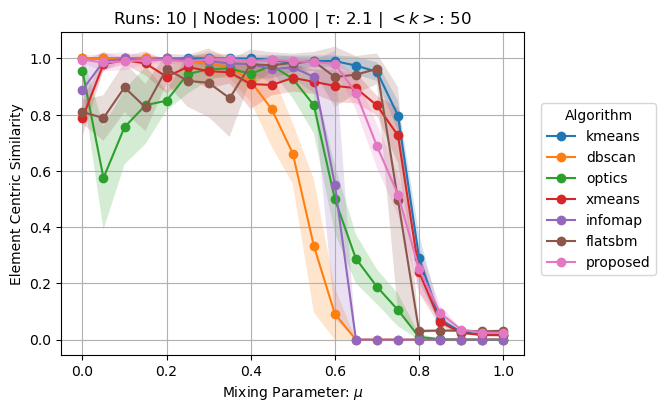

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

# path_name = f"/nobackup/gogandhi/alt_means_sans_k/data/experiment_mu_change_{params['N']}_{params['k']}_{params['tau']}_final"
# csv_file_path = path_name + "/result_stream.csv"

result_df = pd.read_csv(csv_file_path)
df_grouped = result_df.groupby('mu').agg(['mean', 'std'])
plt.figure(figsize=(7,4))

for column in df_grouped.columns.levels[0][1:]:
    
    mean_values = df_grouped[column]['mean']
    std_values = df_grouped[column]['std']
    
    plt.plot(mean_values.index, mean_values, '-o',label=column)
    plt.fill_between(mean_values.index, mean_values - std_values, mean_values + std_values, alpha=0.2)

plt.xlabel(r'Mixing Parameter: $\mu$')
plt.ylabel('Element Centric Similarity')
plt.legend(title="Algorithm", loc='upper right', bbox_to_anchor=(1.3, 0.8))
plt.grid(True)
plt.tight_layout()

plt.title(rf'Runs: {len(runs)} | Nodes: {params["N"]} | $\tau$: {params["tau"]} | $<k>$: {params["k"]}')


# Save the figure
plt.savefig(f"{path_name}/experiment_plot.png",bbox_inches='tight')

# Show the plot
plt.show()

10

In [ ]:
# MOdify this so that snakemake can be used to parallelize mu and runs.
# your_script.py
import argparse

def main():
    parser = argparse.ArgumentParser(description='Experiment: Changing Mu')
    #parser.add_argument('--input', required=True, help='Input file path')
    parser.add_argument('--output', required=True, help='Output file path')
    parser.add_argument('--mu', type=float, required=True, help='Value of mu')
    parser.add_argument('--runs', type=float, required=True, help='Value of mu')

    args = parser.parse_args()

    # Your script logic using args.input, args.output, and args.mu

if __name__ == "__main__":
    main()